In [2]:
#!nvidia-smi

In [3]:
# install tensorflow 2.15 since voxelmorph is not compatible with current build
import tensorflow as tf

if not tf.__version__.startswith('2.15'):
    !pip uninstall -y tensorflow
    !pip install tensorflow==2.15
# install voxelmorph
!pip install voxelmorph


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import voxelmorph as vxm
import neurite as ne

import os
import urllib.request
import zipfile
import json
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors, patches
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [5]:
# download dataset
filename = 'AbdomenCTCT.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/32WaSRaTnFk2JeT/download/AbdomenCTCT.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [6]:
def load_data(jsonData, dataFolderPath, training_or_test, filterString='0001'):
    images = []
    labels = []
    for sample in jsonData[training_or_test]:
        image = nib.load(dataFolderPath + sample['image'].removeprefix('.').replace(".csv", ".nii.gz")).get_fdata()
        images.append(image)
        if training_or_test == 'training':
            label = nib.load(dataFolderPath + sample['label'].removeprefix('.').replace(".csv", ".nii.gz")).get_fdata()
            labels.append(label)

    return np.array(images), np.array(labels)

In [7]:
# load data
with open('./AbdomenCTCT/AbdomenCTCT_dataset.json', 'r') as file:
    data_json = json.load(file)
dataFolder = './AbdomenCTCT'
images_raw, labels_raw = load_data(data_json, dataFolder, 'training')

In [8]:
images_raw.shape

(30, 192, 160, 256)

In [9]:
labels_raw.shape

(30, 192, 160, 256)

# Preprocess data

In [10]:
# choose organ
organs_map = {
    1: "spleen",
    2: "right kidney",
    3: "left kidney",
    4: "gall bladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "inferior vena cava",
    10: "portal and splenic vein",
    11: "pancreas",
    12: "left adrenal gland",
    13: "right adrenal gland"
}

organ_used = 6

In [11]:
# normalize images
images_normalized = (images_raw - np.min(images_raw)) / (np.max(images_raw) - np.min(images_raw))

# rotate tensor
images_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in images_normalized])
labels_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in labels_raw])

# swap and flip axes
images = np.swapaxes(images_rotated, 1, 2)[:, ::-1, :, :]
labels = np.swapaxes(labels_rotated, 1, 2)[:, ::-1, :, :]

# prepare tensor just with organs
organs = np.zeros_like(images)
organs[labels > 0] = images[labels > 0]

In [12]:
del images_raw
del labels_raw
del images_normalized
del images_rotated
del labels_rotated

(-0.5, 191.5, 255.5, -0.5)

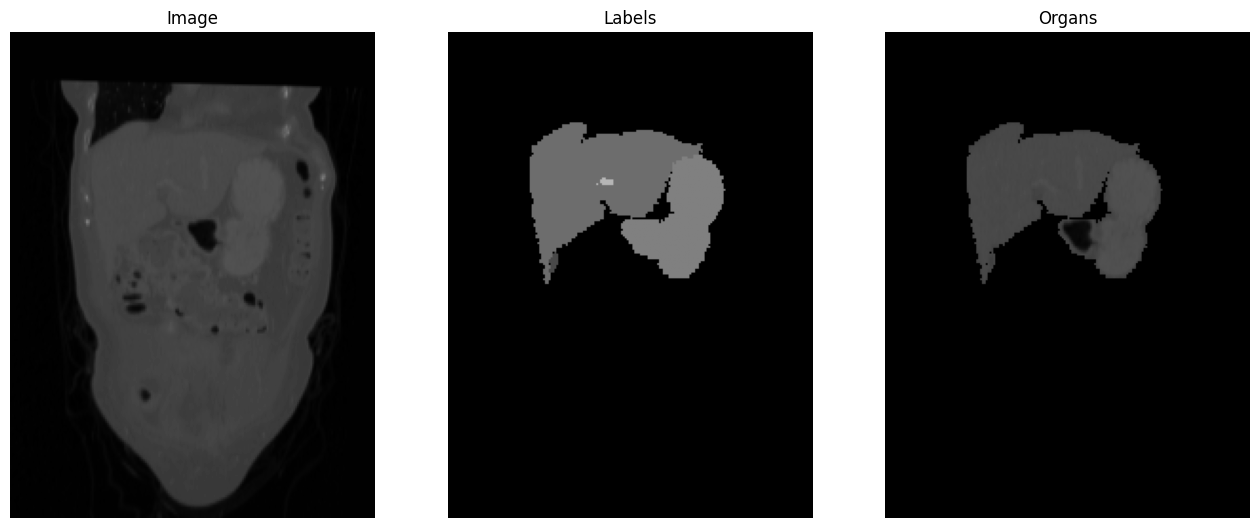

In [13]:
# preview data
img = 0
depth = 40

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 8))
ax0.imshow(images[img, depth], cmap='gray', vmin=0, vmax=1)
ax0.set_title("Image")
ax0.axis("off")
ax1.imshow(labels[img, depth], cmap='gray', vmin=0, vmax=14)
ax1.set_title("Labels")
ax1.axis("off")
ax2.imshow(organs[img, depth], cmap='gray', vmin=0, vmax=1)
ax2.set_title("Organs")
ax2.axis("off")

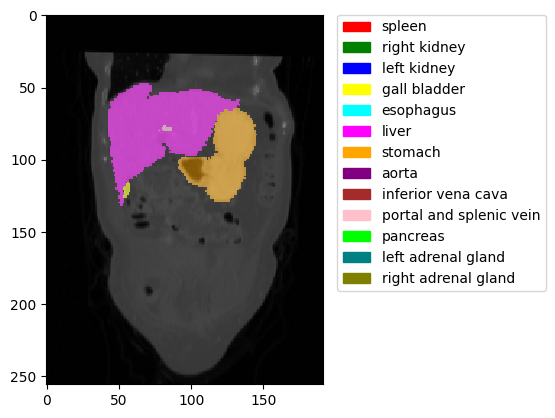

In [14]:
# setup colormap
cmap = colors.ListedColormap([
    'black', 'red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange',
    'purple', 'brown', 'pink', 'lime', 'teal', 'olive'
])
norm = colors.BoundaryNorm(boundaries=np.arange(-0.5, 14, 1), ncolors=14)

# view image
plt.imshow(images[img, depth], cmap='gray', interpolation='none')

# view colors
plt.imshow(labels[img, depth], cmap=cmap, norm=norm, alpha=0.5, interpolation='none')

# setup legend
legend_labels = {
    1: "spleen",
    2: "right kidney",
    3: "left kidney",
    4: "gall bladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "inferior vena cava",
    10: "portal and splenic vein",
    11: "pancreas",
    12: "left adrenal gland",
    13: "right adrenal gland"
}

# view rectangles in legend
patches_list = [
    patches.Patch(color=cmap(i), label=legend_labels[i])
    for i in range(1, 14)
]

# view legend
plt.legend(handles=patches_list, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [15]:
image_label_data = []
for i in range(organs.shape[0]):
    concatSample = [organs[i], labels[i]]
    image_label_data.append(concatSample)

image_label_data = np.array(image_label_data)

In [16]:
image_label_data.shape

(30, 2, 160, 256, 192)

In [17]:
# split dataset
_, test_data = train_test_split(image_label_data, test_size=0.2, random_state=10)

In [18]:
test_data.shape

(6, 2, 160, 256, 192)

# Define Model

In [19]:
print(legend_labels[1])

spleen


In [73]:
# define the input shapes
inshape = test_data.shape[2:]
nb_features = (
    (16, 32, 32),  # encoder-channels
    (32, 32, 16, 16)  # decoder-channels
)

vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
# build model using VxmDense
spleen_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
spleen_model.load_weights('models/AbdomenCTCT_' + legend_labels[1] + '_model.h5')
rkidney_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
rkidney_model.load_weights('models/AbdomenCTCT_' + legend_labels[2] + '_model.h5')
lkidney_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
lkidney_model.load_weights('models/AbdomenCTCT_' + legend_labels[3] + '_model.h5')
gbladder_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
gbladder_model.load_weights('models/AbdomenCTCT_' + legend_labels[4] + '_model.h5')
esophagus_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
esophagus_model.load_weights('models/AbdomenCTCT_' + legend_labels[5] + '_model.h5')
liver_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
liver_model.load_weights('models/AbdomenCTCT_' + legend_labels[6] + '_model.h5')
stomach_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
stomach_model.load_weights('models/AbdomenCTCT_' + legend_labels[7] + '_model.h5')
aorta_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
aorta_model.load_weights('models/AbdomenCTCT_' + legend_labels[8] + '_model.h5')
ivc_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
ivc_model.load_weights('models/AbdomenCTCT_' + legend_labels[9] + '_model.h5')
pandsvein_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
pandsvein_model.load_weights('models/AbdomenCTCT_' + legend_labels[10] + '_model.h5')
pancreas_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
pancreas_model.load_weights('models/AbdomenCTCT_' + legend_labels[11] + '_model.h5')
ladrenalgland_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
ladrenalgland_model.load_weights('models/AbdomenCTCT_' + legend_labels[12] + '_model.h5')
radrenalgland_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
radrenalgland_model.load_weights('models/AbdomenCTCT_' + legend_labels[13] + '_model.h5')

# Test registration

In [21]:
# define a data generator
def test_data_generator(data):
    while True:
        idx1 = np.random.randint(0, data.shape[0], size=1)
        idx2 = np.random.randint(0, data.shape[0], size=1)
        while idx2 == idx1:
            idx2 = np.random.randint(0, data.shape[0], size=1)

        fixed_image = data[idx1, 0, ..., np.newaxis]
        fixed_labels = data[idx1, 1, ..., np.newaxis]

        moving_image = data[idx2, 0, ..., np.newaxis]
        moving_labels = data[idx2, 1, ..., np.newaxis]

        yield fixed_image, fixed_labels, moving_image, moving_labels

In [22]:
# define validation generator
test_generator = test_data_generator(test_data)

In [23]:
# get test sample
generator_output = next(test_generator)

In [24]:
print(generator_output[0].shape)

(1, 160, 256, 192, 1)


In [46]:
fixed_input = np.zeros_like(generator_output[0])
fixed_input[generator_output[1] == organ_used] = generator_output[0][generator_output[1] == organ_used]
moving_input = np.zeros_like(generator_output[2])
moving_input[generator_output[3] == organ_used] = generator_output[2][generator_output[3] == organ_used]
print(fixed_input.shape)

test_input = (fixed_input, moving_input)

(1, 160, 256, 192, 1)


In [26]:
# perform prediction
test_pred = tuple(liver_model.predict(test_input))

1/1 [==============================] - 9s 9s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.077513..2.683493].


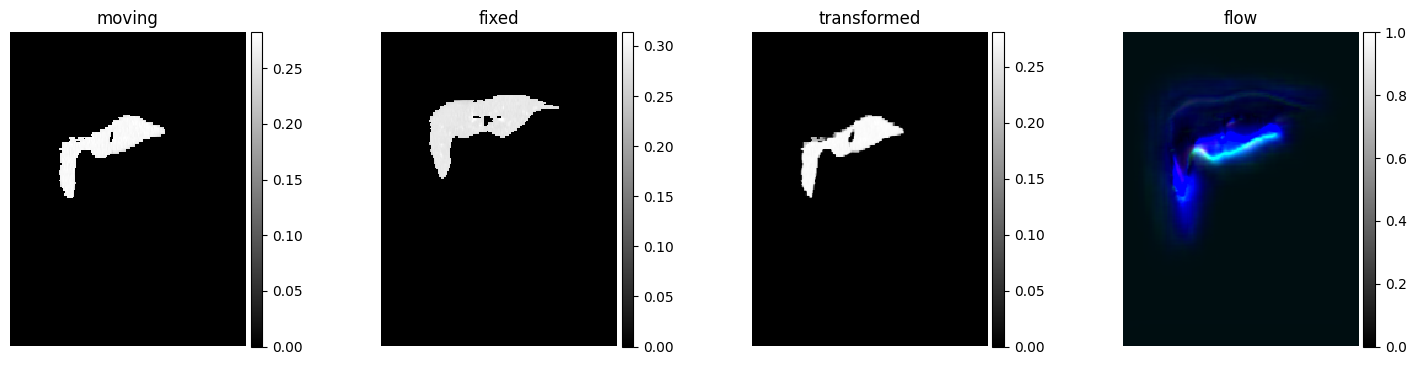

In [59]:
# view result
images = [img[0, depth] for img in test_input + test_pred]
titles = ['moving', 'fixed', 'transformed', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [32]:
test_data.shape

(6, 2, 160, 256, 192)

In [36]:
test_data[0, 0].shape

(160, 256, 192)

In [94]:
each_org_transformation = []

for organ in tqdm(legend_labels):
    fixed_input = np.zeros_like(test_data[0, 0])
    fixed_input[test_data[0, 1] == organ] = test_data[0, 0][test_data[0, 1] == organ]
    moving_input = np.zeros_like(test_data[1, 0])
    moving_input[test_data[1, 1] == organ] = test_data[1, 0][test_data[1, 1] == organ]
    test_input = (fixed_input[np.newaxis, ..., np.newaxis], moving_input[np.newaxis, ..., np.newaxis])

    # vxm_model.load_weights('models/AbdomenCTCT_' + legend_labels[organ] + '_model.h5')
    # test_pred = tuple(vxm_model.predict(test_input))
    if organ == 1:
        test_pred = tuple(spleen_model.predict(test_input))
    elif organ == 2:
        test_pred = tuple(rkidney_model.predict(test_input))
    elif organ == 3:
        test_pred = tuple(lkidney_model.predict(test_input))
    elif organ == 4:
        test_pred = tuple(gbladder_model.predict(test_input))
    elif organ == 5:
        test_pred = tuple(esophagus_model.predict(test_input))
    elif organ == 6:
        test_pred = tuple(liver_model.predict(test_input))
    elif organ == 7:
        test_pred = tuple(stomach_model.predict(test_input))
    elif organ == 8:
        test_pred = tuple(aorta_model.predict(test_input))
    elif organ == 9:
        test_pred = tuple(ivc_model.predict(test_input))
    elif organ == 10:
        test_pred = tuple(pandsvein_model.predict(test_input))
    elif organ == 11:
        test_pred = tuple(pancreas_model.predict(test_input))
    elif organ == 12:
        test_pred = tuple(ladrenalgland_model.predict(test_input))
    else:
        test_pred = tuple(radrenalgland_model.predict(test_input))

    each_org_transformation.append(test_pred[0][0])

  0%|          | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


  8%|▊         | 1/13 [00:04<00:50,  4.17s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 2/13 [00:06<00:36,  3.29s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 3/13 [00:09<00:29,  2.92s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 4/13 [00:11<00:24,  2.76s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 5/13 [00:14<00:21,  2.67s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 6/13 [00:16<00:18,  2.60s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 7/13 [00:19<00:15,  2.54s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 8/13 [00:21<00:12,  2.52s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 9/13 [00:24<00:10,  2.52s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 10/13 [00:26<00:07,  2.49s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 11/13 [00:29<00:04,  2.45s/it]

1/1 [==============================] - 3s 3s/step


 92%|█████████▏| 12/13 [00:32<00:02,  2.66s/it]

1/1 [==============================] - 3s 3s/step


100%|██████████| 13/13 [00:35<00:00,  2.70s/it]


(-0.5, 191.5, 255.5, -0.5)

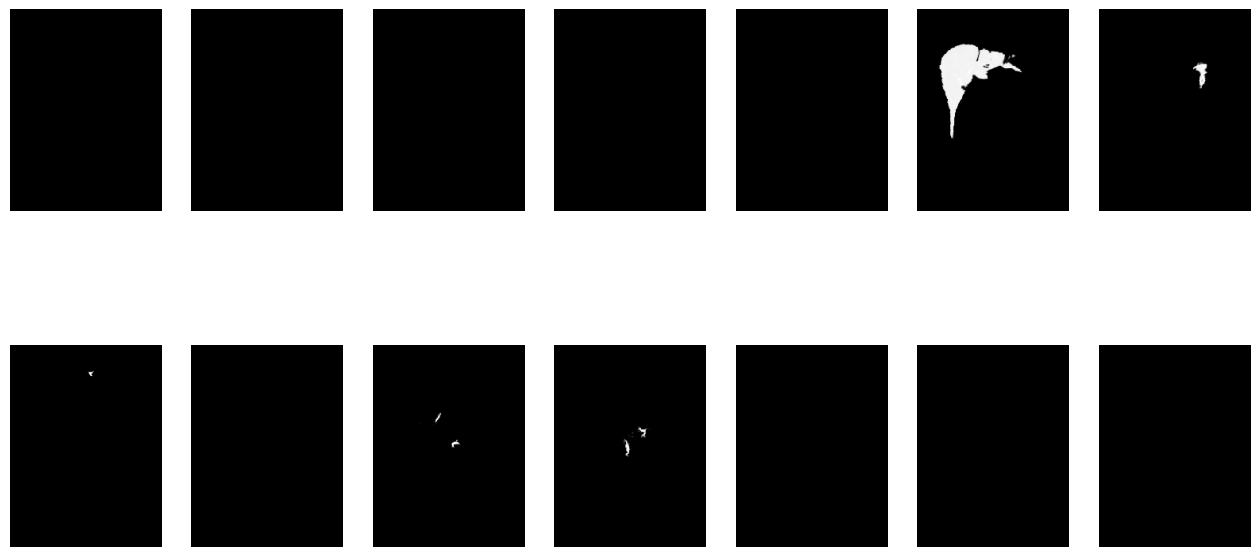

In [95]:
depth = 60

fig, ax = plt.subplots(ncols=7, nrows=2, figsize=(16, 8))
ax[0, 0].imshow(each_org_transformation[0][depth], cmap='gray')
ax[0, 0].axis('off')
ax[0, 1].imshow(each_org_transformation[1][depth], cmap='gray')
ax[0, 1].axis('off')
ax[0, 2].imshow(each_org_transformation[2][depth], cmap='gray')
ax[0, 2].axis('off')
ax[0, 3].imshow(each_org_transformation[3][depth], cmap='gray')
ax[0, 3].axis('off')
ax[0, 4].imshow(each_org_transformation[4][depth], cmap='gray')
ax[0, 4].axis('off')
ax[0, 5].imshow(each_org_transformation[5][depth], cmap='gray')
ax[0, 5].axis('off')
ax[0, 6].imshow(each_org_transformation[6][depth], cmap='gray')
ax[0, 6].axis('off')
ax[1, 0].imshow(each_org_transformation[7][depth], cmap='gray')
ax[1, 0].axis('off')
ax[1, 1].imshow(each_org_transformation[8][depth], cmap='gray')
ax[1, 1].axis('off')
ax[1, 2].imshow(each_org_transformation[9][depth], cmap='gray')
ax[1, 2].axis('off')
ax[1, 3].imshow(each_org_transformation[10][depth], cmap='gray')
ax[1, 3].axis('off')
ax[1, 4].imshow(each_org_transformation[11][depth], cmap='gray')
ax[1, 4].axis('off')
ax[1, 5].imshow(each_org_transformation[12][depth], cmap='gray')
ax[1, 5].axis('off')
ax[1, 6].imshow(np.zeros_like(each_org_transformation[12][depth]), cmap='gray')
ax[1, 6].axis('off')



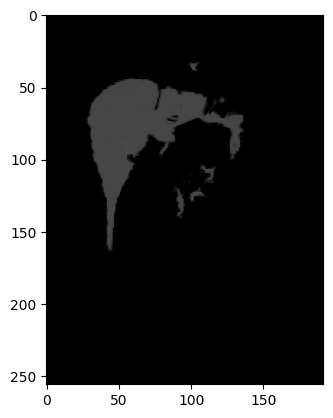

In [98]:
combination = np.maximum.reduce(each_org_transformation)

plt.imshow(combination[depth], cmap='gray', vmin=0, vmax=1)

In [107]:
def predict_organs(fixed_image, moving_image):
    each_org_transformation = []

    for organ in legend_labels:
        fixed_input = np.zeros_like(fixed_image[0])
        fixed_input[fixed_image[1] == organ] = fixed_image[0][fixed_image[1] == organ]

        moving_input = np.zeros_like(moving_image[0])
        moving_input[moving_image[1] == organ] = moving_image[0][moving_image[1] == organ]
        test_input = (fixed_input[np.newaxis, ..., np.newaxis], moving_input[np.newaxis, ..., np.newaxis])

        # vxm_model.load_weights('models/AbdomenCTCT_' + legend_labels[organ] + '_model.h5')
        # test_pred = tuple(vxm_model.predict(test_input))
        if organ == 1:
            test_pred = tuple(spleen_model.predict(test_input))
        elif organ == 2:
            test_pred = tuple(rkidney_model.predict(test_input))
        elif organ == 3:
            test_pred = tuple(lkidney_model.predict(test_input))
        elif organ == 4:
            test_pred = tuple(gbladder_model.predict(test_input))
        elif organ == 5:
            test_pred = tuple(esophagus_model.predict(test_input))
        elif organ == 6:
            test_pred = tuple(liver_model.predict(test_input))
        elif organ == 7:
            test_pred = tuple(stomach_model.predict(test_input))
        elif organ == 8:
            test_pred = tuple(aorta_model.predict(test_input))
        elif organ == 9:
            test_pred = tuple(ivc_model.predict(test_input))
        elif organ == 10:
            test_pred = tuple(pandsvein_model.predict(test_input))
        elif organ == 11:
            test_pred = tuple(pancreas_model.predict(test_input))
        elif organ == 12:
            test_pred = tuple(ladrenalgland_model.predict(test_input))
        else:
            test_pred = tuple(radrenalgland_model.predict(test_input))

        each_org_transformation.append(test_pred[0][0])

    combination = np.maximum.reduce(each_org_transformation)

    return np.squeeze(combination)

1/1 [==============================] - 2s 2s/step
(160, 256, 192)


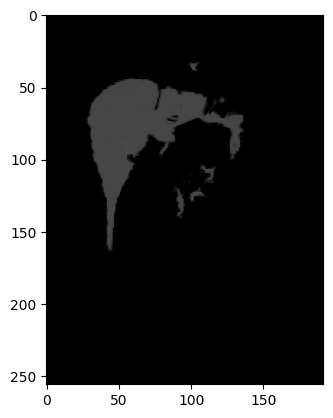

In [108]:
combination = predict_organs(test_data[0], test_data[1])
print(combination.shape)

plt.imshow(combination[depth], cmap='gray', vmin=0, vmax=1)

# Evaluation

In [109]:
def dice_score_tf(y_true, y_pred, smooth=1e-6):
    binary_y_true = tf.cast(y_true > 0, tf.float32)
    binary_y_pred = tf.cast(y_pred > 0, tf.float32)

    y_true_flat = tf.reshape(binary_y_true, [-1])
    y_pred_flat = tf.reshape(binary_y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)

    dice = (2. * intersection + smooth) / (union + smooth)
    return float(dice)

In [110]:
n = test_data.shape[0]
count = 0
dice = 0
mse = 0

for i in tqdm(range(n)):
    for j in range(n):
        if i == j:
            continue
        else:
            count += 1
            combined_prediction = predict_organs(test_data[i], test_data[j])
            dice += dice_score_tf(test_data[j][0], combined_prediction)
            mse += np.mean(np.square(test_data[j][0] - combined_prediction))

print("Dice: " + str(dice / count))
print("MSE: " + str(mse / count))

  0%|          | 0/6 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 1/6 [02:54<14:33, 174.65s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 2/6 [05:35<11:06, 166.53s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 3/6 [08:04<07:56, 158.70s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 4/6 [10:44<05:17, 158.91s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 5/6 [13:14<02:35, 155.75s/it]

1/1 [==============================] - 3s 3s/step


100%|██████████| 6/6 [15:43<00:00, 157.18s/it]

Dice: 0.7544242997964223
MSE: 0.001590063323412542
